In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_ds = torchvision.datasets.SVHN(
    root="./data",
    split="train",
    transform=transform,
    download=True
)

test_ds = torchvision.datasets.SVHN(
    root="./data",
    split="test",
    transform=transform,
    download=True
)

len(train_ds), len(test_ds)


100%|██████████| 182M/182M [00:02<00:00, 67.8MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 46.6MB/s]


(73257, 26032)

In [7]:
batch_size = 64

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


In [8]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)


In [9]:
def train_one_epoch(model, loader):
    model.train()
    loss_sum = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
        loss_sum += loss.item()
    return loss_sum / len(loader)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        out = model(x)
        p = out.argmax(1).cpu().numpy()
        ys.append(y.numpy())
        ps.append(p)
    return np.concatenate(ys), np.concatenate(ps)


In [10]:
for ep in range(1,6):
    loss = train_one_epoch(model, train_loader)
    yt, pt = evaluate(model, test_loader)
    print(f"Epoch {ep} | test_acc={accuracy_score(yt, pt):.3f}")


Epoch 1 | test_acc=0.894
Epoch 2 | test_acc=0.932
Epoch 3 | test_acc=0.933
Epoch 4 | test_acc=0.931
Epoch 5 | test_acc=0.936


In [11]:
yt, pt = evaluate(model, test_loader)

print("Overall accuracy:", accuracy_score(yt, pt))

for d in range(10):
    idx = yt == d
    print(f"Digit {d} accuracy:", accuracy_score(yt[idx], pt[idx]))


Overall accuracy: 0.9357329440688383
Digit 0 accuracy: 0.9678899082568807
Digit 1 accuracy: 0.9450872720141205
Digit 2 accuracy: 0.9570980959267293
Digit 3 accuracy: 0.9240111034004164
Digit 4 accuracy: 0.9159730479587792
Digit 5 accuracy: 0.925755033557047
Digit 6 accuracy: 0.9327263530601922
Digit 7 accuracy: 0.9450222882615156
Digit 8 accuracy: 0.903012048192771
Digit 9 accuracy: 0.9084639498432602


In [12]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "#ff3333",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "figure.autolayout": True,
    "axes.titleweight": "bold",
    "axes.titlecolor": "white",
    "grid.color": "#444444",
})

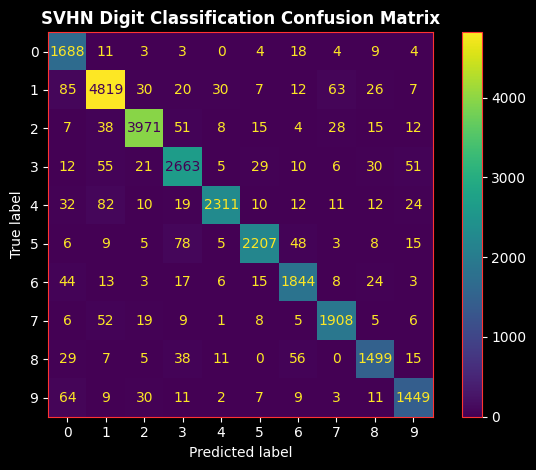

In [13]:
cm = confusion_matrix(yt, pt)
ConfusionMatrixDisplay(cm).plot()
plt.title("SVHN Digit Classification Confusion Matrix")
plt.show()


In [14]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx):
        self.model.zero_grad()
        out = self.model(x)
        out[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam / cam.max()
        return cam


In [15]:
cam = GradCAM(model, model.layer4[-1].conv2)

def show_cam(idx):
    img, label = test_ds[idx]
    x = img.unsqueeze(0).to(device)
    pred = model(x).argmax(1).item()

    heatmap = cam(x, pred)[0].cpu().numpy()
    img_np = img.permute(1,2,0).numpy()
    img_np = (img_np * 0.5 + 0.5)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title(f"Digit {label} | Pred {pred}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap="jet", alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


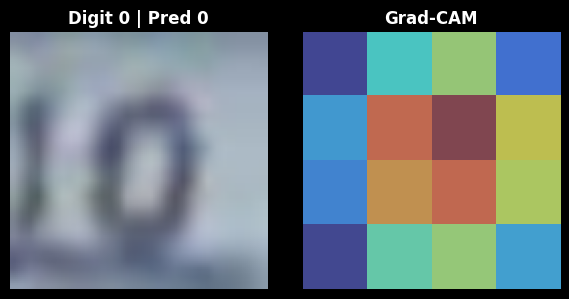

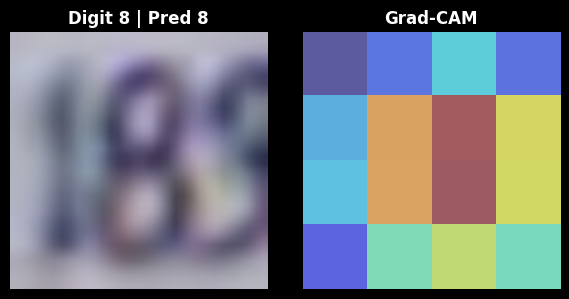

In [16]:
# Easy digit (0)
for i in range(len(test_ds)):
    if test_ds[i][1] == 0:
        show_cam(i)
        break

# Hard digit (8)
for i in range(len(test_ds)):
    if test_ds[i][1] == 8:
        show_cam(i)
        break


In [20]:
def fgsm_attack(model, x, y, epsilon):
    x = x.clone().detach().to(device)
    x.requires_grad = True

    out = model(x)
    loss = F.cross_entropy(out, y)

    model.zero_grad()
    loss.backward()

    grad_sign = x.grad.sign()
    x_adv = x + epsilon * grad_sign
    x_adv = torch.clamp(x_adv, -1, 1)

    return x_adv.detach()


In [21]:
def evaluate_attack(model, loader, epsilon):
    model.eval()
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # FGSM needs gradients
        x_adv = fgsm_attack(model, x, y, epsilon)

        # Now disable grads for evaluation
        with torch.no_grad():
            preds = model(x_adv).argmax(1)

        correct += (preds == y).sum().item()
        total += y.numel()

    return correct / total


In [22]:
epsilons = [0.0, 0.01, 0.03, 0.07, 0.1]
robust_acc = []

for eps in epsilons:
    acc = evaluate_attack(model, test_loader, eps)
    robust_acc.append(acc)
    print(f"Epsilon {eps:.2f} | Accuracy {acc:.3f}")


Epsilon 0.00 | Accuracy 0.936
Epsilon 0.01 | Accuracy 0.640
Epsilon 0.03 | Accuracy 0.222
Epsilon 0.07 | Accuracy 0.043
Epsilon 0.10 | Accuracy 0.020


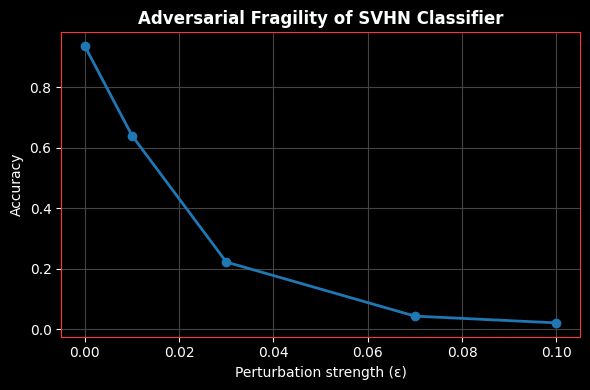

In [23]:
plt.figure(figsize=(6,4))
plt.plot(epsilons, robust_acc, marker="o", linewidth=2)
plt.xlabel("Perturbation strength (ε)")
plt.ylabel("Accuracy")
plt.title("Adversarial Fragility of SVHN Classifier")
plt.grid(True)
plt.show()


In [24]:
def show_adv_example(idx, epsilon):
    img, label = test_ds[idx]
    x = img.unsqueeze(0).to(device)
    y = torch.tensor([label]).to(device)

    x_adv = fgsm_attack(model, x, y, epsilon)

    with torch.no_grad():
        pred_clean = model(x).argmax(1).item()
        pred_adv = model(x_adv).argmax(1).item()

    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = img_np * 0.5 + 0.5

    adv_np = x_adv[0].permute(1,2,0).cpu().numpy()
    adv_np = adv_np * 0.5 + 0.5

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title(f"Clean | pred={pred_clean}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(adv_np)
    plt.title(f"Adversarial (ε={epsilon}) | pred={pred_adv}")
    plt.axis("off")
    plt.show()


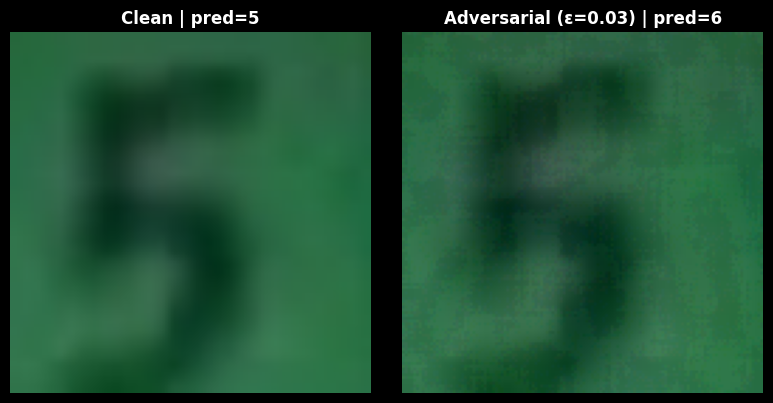

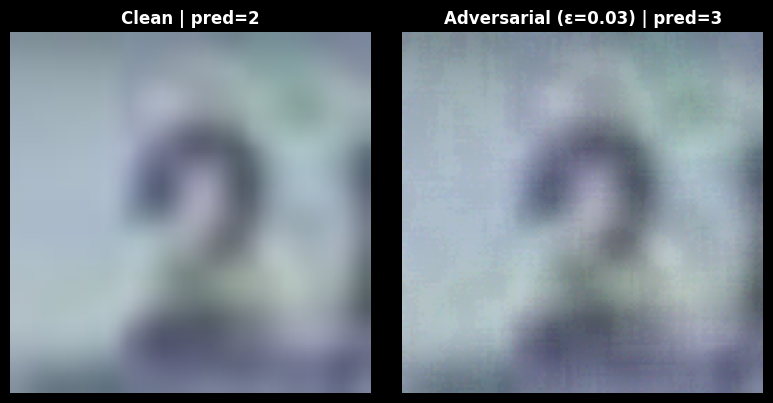

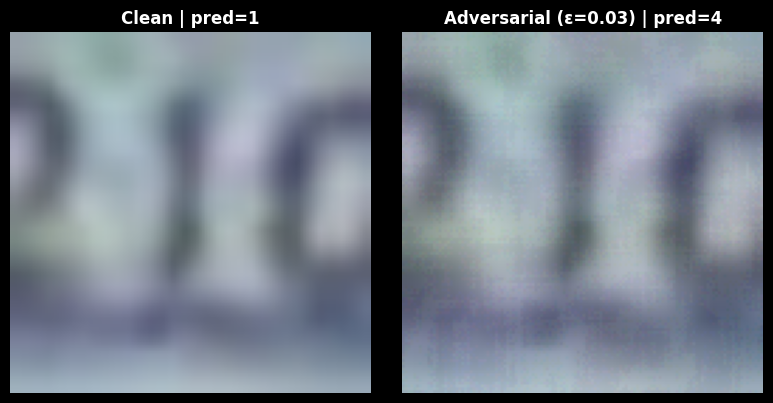

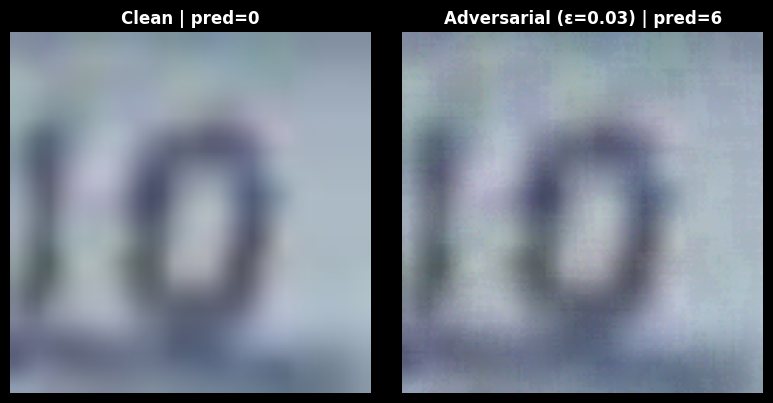

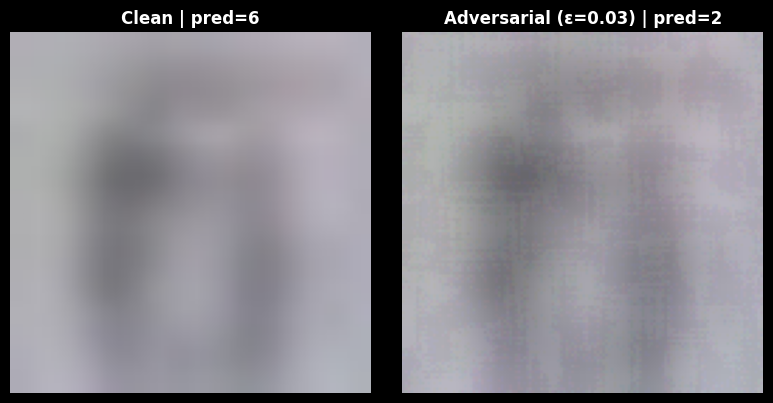

In [25]:
for i in range(5):
    show_adv_example(i, epsilon=0.03)
